# k-Means Analysis of Autoencoder Latent Vectors

This notebook analyzes the output latent vectors from an autoencoder. <br>
k-Means clustering using between 2-6 clusters is performed and scored.  The options for scoring include:
* Adjusted Mutual Information
* Adjusted Rand Index
* Completeness
* Fowlkes-Mallows Index
* Homogeneity
* Inertia (Sum-Of-Square Distances)
* Silhouette
* V-Measure <br>

The truth for the clusters is considered to be the cloud type, which is the type of cloud most prevalent in the same 20x20 grid cell.  The cloud types are:
* 0: Clear
* 2: Fog
* 3: Water Cloud
* 4: Supercooled Water
* 7: Cirrus
* 8: Overlapping

## 1  Setup

### Experiment to Investigate

In [1]:
archHere='CAE'
exHere='ex6'

### List Data Available

In [2]:
archList = ['CAE','SAE']
exList = ['ex0','ex1','ex2','ex3','ex4','ex5','ex6']
range_n_clusters = [2, 3, 4, 5, 6]

### Setup Google Drive

In [3]:
useGoogle = False

In [4]:
# Set directories
if useGoogle:
    from google.colab import drive
    drive.mount('/content/drive')
    dirIn = '/content/drive/My Drive/classes/cs535/Project/kmeans/'
else:
    dirIn = './'
    
figPrefix = dirIn + 'figs/'
savePrefix = dirIn + 'save/' + archHere + '/' + exHere

In [5]:
# Load Libraries
import ast
import numpy as np
import pandas as pd
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import completeness_score, fowlkes_mallows_score
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.metrics import silhouette_score, silhouette_samples

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rc('font', family='serif', size=11)

In [6]:
# Set Plotting Sizes and Colors
SMALL_SIZE = 13
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

COLORS = pl.cm.tab10(np.linspace(0, 1, 10))
LSTYLE = ['solid','dashed','dotted']
EXCOLOR = ['violet','deeppink','darkorange','mediumseagreen',
           'royalblue','navy','gray']
EXLWIDTH = 2.
#EXCOLOR = ['darkblue','slateblue','darkviolet','fuchsia','crimson',
#            'orangered','goldenrod','darkolivegreen','darkslategrey']

FIGDPI = 150

### Define Functions

In [7]:
# Function to report if variable exists
def exists(var):
    var_exists = var in locals() or var in globals()
    return var_exists

In [8]:
# Function to read results file
def read_results(archi='CAE',dataSet='ex0'):

    fileLV = dirIn + 'results/' + archi + '/' + dataSet + '/latent_vectors.csv'

    dataLV = pd.read_csv(fileLV, index_col=[0])
    dataLV.latent_vector = dataLV.latent_vector.map(lambda x: ast.literal_eval(x))
    dataLV.latent_vector = dataLV.latent_vector.map(lambda x: np.asarray(x))

    # ...save latent vector
    latentV = np.asarray([dataLV.latent_vector[i] 
                          for i in range(len(dataLV.latent_vector))])

    # ...save labels, combining 1+2, 4+6, 8+9
    labelV = np.asarray(dataLV.label)
    lab1Ref = np.where(labelV == 1)
    labelV[lab1Ref] = 0
    lab6Ref = np.where(labelV == 6)
    labelV[lab6Ref] = 4
    lab9Ref = np.where(labelV == 9)
    labelV[lab9Ref] = 8
    ctypes, ccounts = np.unique(labelV, return_counts=True)
    clabels = [str(i) for i in ctypes]

    nSamples = latentV.shape[0]
    nLSpace = latentV.shape[1]
    print('Read in Latent Vector.')
    print('   Shape: {}'.format(list(latentV.shape)))
    print('   Number of Cloud Types: {}'.format(len(ctypes)))
    
    return latentV, labelV, ctypes, ccounts, clabels

In [9]:
# Function to subsample the results
def subsample(latentV, labelV, nSamples=500):

    latVNew = latentV.copy()
    labVNew = labelV.copy()
    
    rng_state = np.random.get_state()
    np.random.shuffle(labVNew)
    np.random.set_state(rng_state)
    np.random.shuffle(latVNew)

    labVNew = labVNew[:nSamples]
    latVNew = latVNew[:nSamples,:]
    print('Subset.')
    print('   Orig Shape: {}'.format(list(latentV.shape)))
    print('   New Shape: {}'.format(list(latVNew.shape)))
    
    return latVNew, labVNew

def subsample3(latentV, labelV, labelP, nSamples=500, verbose=False):

    latVNew = latentV.copy()
    labVNew = labelV.copy()
    labPNew = labelP.copy()
    
    rng_state = np.random.get_state()
    np.random.shuffle(labVNew)
    np.random.set_state(rng_state)
    np.random.shuffle(latVNew)
    np.random.set_state(rng_state)
    np.random.shuffle(labPNew)

    labVNew = labVNew[:nSamples]
    latVNew = latVNew[:nSamples,:]
    labPNew = labPNew[:nSamples]
    
    if verbose:
        print('Subset 3 Vectors')
        print('   Orig Shape: {}'.format(list(latentV.shape)))
        print('   New Shape: {}'.format(list(latVNew.shape)))
    
    return latVNew, labVNew, labPNew

In [10]:
# Function to read k-means output
def load_kMeans(archList=archList, exList=exList):
    
    varList = ['labelP','labelV','modelP','latentV']
    
    resDict = {}
    for aa in archList:
        exDict = {}
        for ex in exList:
            inKFile = dirIn + 'save/' + aa + '/' + ex  + '_kClusters.pkl'        
            with open(inKFile, 'rb') as handle:
                    allTemp = pickle.load(handle)
    
            varDict = {}
            for v in varList:
                varDict[v] = allTemp[v]

            exDict[ex] = varDict
        resDict[aa] = exDict
    
    return resDict

In [11]:
# Function to read average silhouette scores
def load_aveSScore(archList=archList, exList=exList):
    
    ssDict = {}
    for aa in archList:
        exDict = {}
        for ex in exList:
            inSSFile = dirIn + 'save/' + aa + '/' + ex + '_avgSS.pkl'
            with open(inSSFile, 'rb') as handle:
                STemp = pickle.load(handle)
            exDict[ex] = STemp
        ssDict[aa] = exDict
        
    return ssDict

In [12]:
# Function to plot silhouette samples
def plotSilhSamples(n_clusters, silhouette_avg, silhSamples, 
                    cluster_labels, cluster_points, 
                    myTitle='', mySave=False, mySaveFile=''):
    
        #Create a subplot with 1 row and 2 columns
        fig = plt.figure(figsize=(13,5))
        ax1 = fig.add_subplot(1, 2, 1)
        
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-.1,1])
        
        # The (n_clusters+1)*10 is for inserting blank space between 
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(cluster_points) + (n_clusters + 1)*10])
        
        y_lower=10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to 
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                silhSamples[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
            
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10
            
        if myTitle == '':
            myTitle = 'Silhouette Plot for {} Clusters'.format(n_clusters)
        ax1.set_title(myTitle)
        ax1.set_xlabel("Silhouette Coefficient")
        ax1.set_ylabel("Cluster")
        
        # The vertical line for average silhouette score of all values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.2, 0.2, 0.6, 1])

        # Write out average silhouette score
        #sString = 'Score = {:.2f}'.format(silhouette_avg)
        #ax1.text(silhouette_avg+0.05, 11, sString)
        
        # 2nd Plot showing actual clusters formed
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(cluster_points[:,0], cluster_points[:,1], cluster_points[:,2],
                    marker='.', alpha=0.7, c=colors, edgecolor=colors)
        every_nth=2
        for n, label in enumerate(ax2.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        for n, label in enumerate(ax2.yaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        for n, label in enumerate(ax2.zaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        #ax2.set_xlabel('X')
        #ax2.set_ylabel('Y')
        #ax2.set_zlabel('')
        ax2.set_title("Visualization of {} Clusters".format(n_clusters), loc='left')
        #ax2.view_init(elev=10., azim=20)
        
        if mySave:
            if mySaveFile == '':
                mySaveFile = archHere + '_' + exHere + str(n_clusters) + 'kSS.png'
            plt.savefig(mySaveFile,bbox_inches='tight',dpi=FIGDPI)
            print('Saved Figure: ',mySaveFile)
            
        else:
            plt.show()

# 2 Data and Latent Vector Plots

### Truth Unique Counts

In [13]:
plotCounts = True
saveCounts = False

Read in Latent Vector.
   Shape: [219904, 3]
   Number of Cloud Types: 6
Cloud Frequency:  [0.22930915 0.13349007 0.4661807  0.06626073 0.05716585 0.0475935 ]


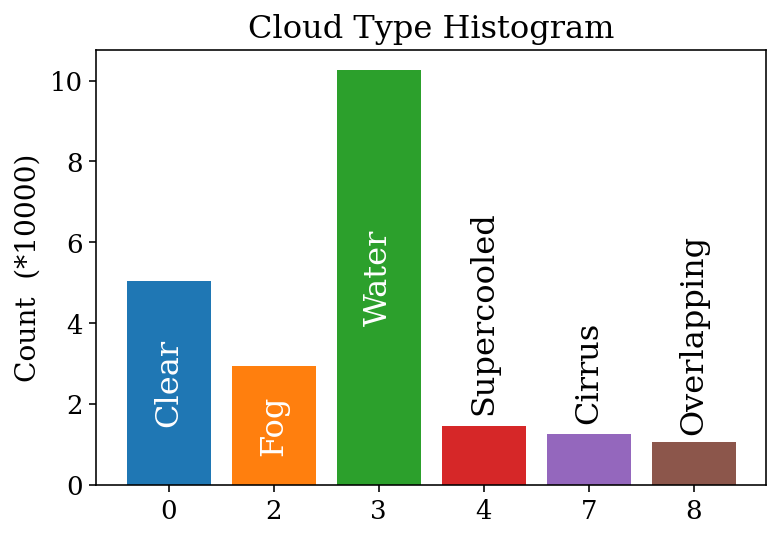

In [14]:
# Plot the unique counts
if plotCounts:
    
    valDivide = 10000.
    cloudTypes = ['Clear','Fog','Water','Supercooled','Cirrus','Overlapping']
    
    # From the results directly
    _, _, _, ccounts, clabels = read_results(archHere,exHere)
    
    # Print the frequencies
    cfreq = ccounts/sum(ccounts)
    print('Cloud Frequency: ',cfreq)
    
    ccounts = np.array(ccounts)/valDivide
    plt.bar(clabels, ccounts, color=COLORS[np.arange(len(clabels))])
    #plt.xticks(clabels,labels=cloudTypes,rotation=30)
    plt.xticks(clabels)
    #plt.xlabel('Cloud Type')
    plt.title('Cloud Type Histogram')
    myYLabel = 'Count  (*' + str(int(valDivide)) + ')'
    plt.ylabel(myYLabel)
    
    for i in range(len(ccounts)):
        if i > 2:
            plt.text(i, ccounts[i]*1.2, cloudTypes[i], horizontalalignment='center', 
                 verticalalignment='bottom',rotation=90,color='k')
        else:
            plt.text(i, ccounts[i]*0.5, cloudTypes[i], horizontalalignment='center', 
                 verticalalignment='center',rotation=90,color='w')
    
    if saveCounts:
        fileName = figPrefix + 'true_counts.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)
    else:
        plt.show()

### 2-Way Interaction Plots

In [18]:
plot2DN = True
save2DN = False

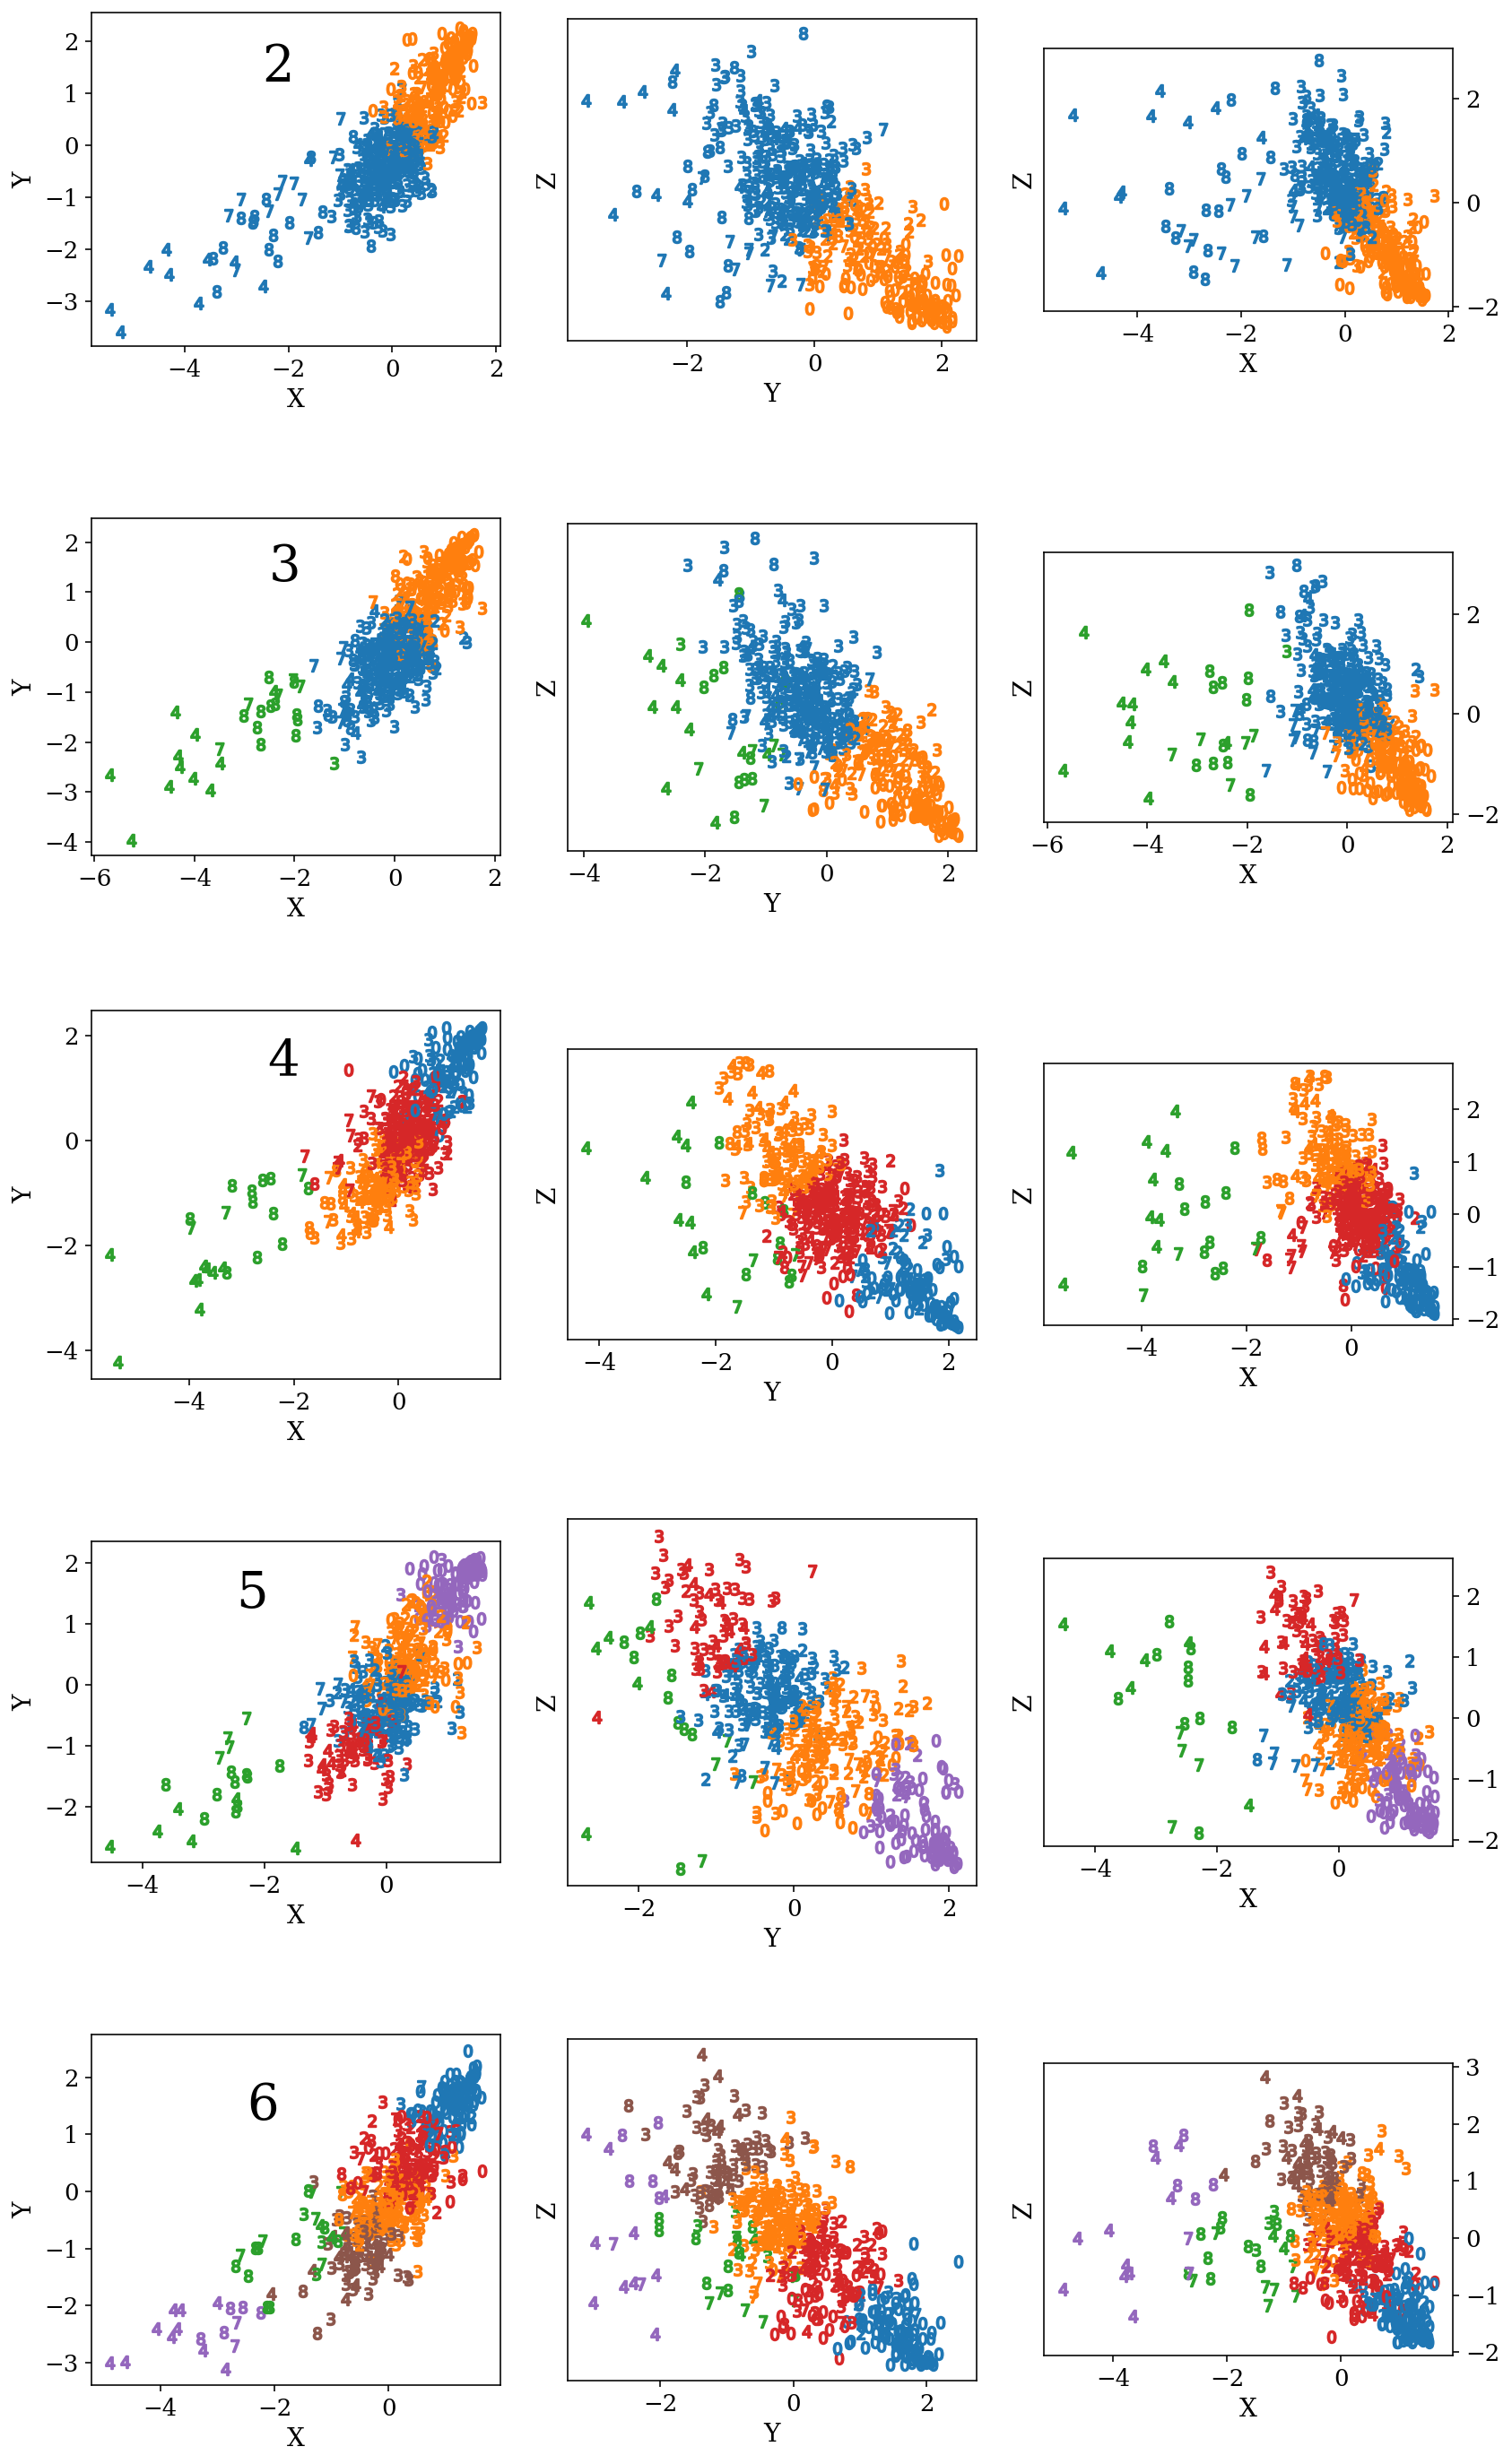

In [19]:
# Create 2-Way Interaction Plots
if plot2DN:
    
    kDict = load_kMeans()

    varDict = kDict[archHere][exHere]
    labelPAll = varDict['labelP']
    labelV = varDict['labelV']
    latentV = varDict['latentV']
    ctypes, ccounts = np.unique(labelV, return_counts=True)
    clabels = [str(i) for i in ctypes]
    
    fig = plt.figure(figsize=(12,20))
    ocount=1
    for n_clusters in range_n_clusters:
        labelP = labelPAll[n_clusters]
        latVHere, labVHere, labPHere = subsample3(latentV, labelV, labelP)
                
        for itr in range(3):

            ax = fig.add_subplot(5, 3, ocount, aspect='equal')
        
            if itr == 0:
                count=0
                for row in latVHere:
                    tHere = labVHere[count]
                    pNow = labPHere[count]
                    ax.scatter(row[0], row[1],
                        marker='${}$'.format(tHere), 
                        s=45, c=[COLORS[pNow]])
                    count+=1
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                ax.text(-2.2, 1.5, str(n_clusters), 
                        fontsize=28, 
                        horizontalalignment='center',
                        verticalalignment='center')

            if itr == 1:
                count=0
                for row in latVHere:
                    tHere = labVHere[count]
                    pNow = labPHere[count]
                    ax.scatter(row[1], row[2],
                        marker='${}$'.format(tHere), 
                        s=45, c=[COLORS[pNow]])
                    count+=1
                ax.set_xlabel('Y')
                ax.set_ylabel('Z')
                ax.get_yaxis().set_ticks([])

            if itr == 2:
                count=0
                for row in latVHere:
                    tHere = labVHere[count]
                    pNow = labPHere[count]
                    ax.scatter(row[0], row[2], marker='${}$'.format(tHere), 
                               s=45, c=[COLORS[pNow]])
                    count+=1
                ax.set_xlabel('X')
                ax.set_ylabel('Z')
                ax.yaxis.tick_right()
            
            ocount+=1
                
    if save2DN:
        fileName = figPrefix + aa + '_' + ee + '_' + 'Sample2D.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)
    else:
        plt.tight_layout()
        plt.show()

# Helpful tricks
#ax.xaxis.tick_top()
#ax.yaxis.tick_right()
#ax.get_xaxis().set_ticks([])
#ax.get_yaxis().set_ticks([])
#ax.text(0.5, 0.5, 'Y', fontsize=48, horizontalalignment='center',
#           verticalalignment='center')

### 3D Latent Space

In [20]:
plot3DSample = True
save3DSample = False

Read in Latent Vector.
   Shape: [219904, 3]
   Number of Cloud Types: 6
Subset.
   Orig Shape: [219904, 3]
   New Shape: [500, 3]


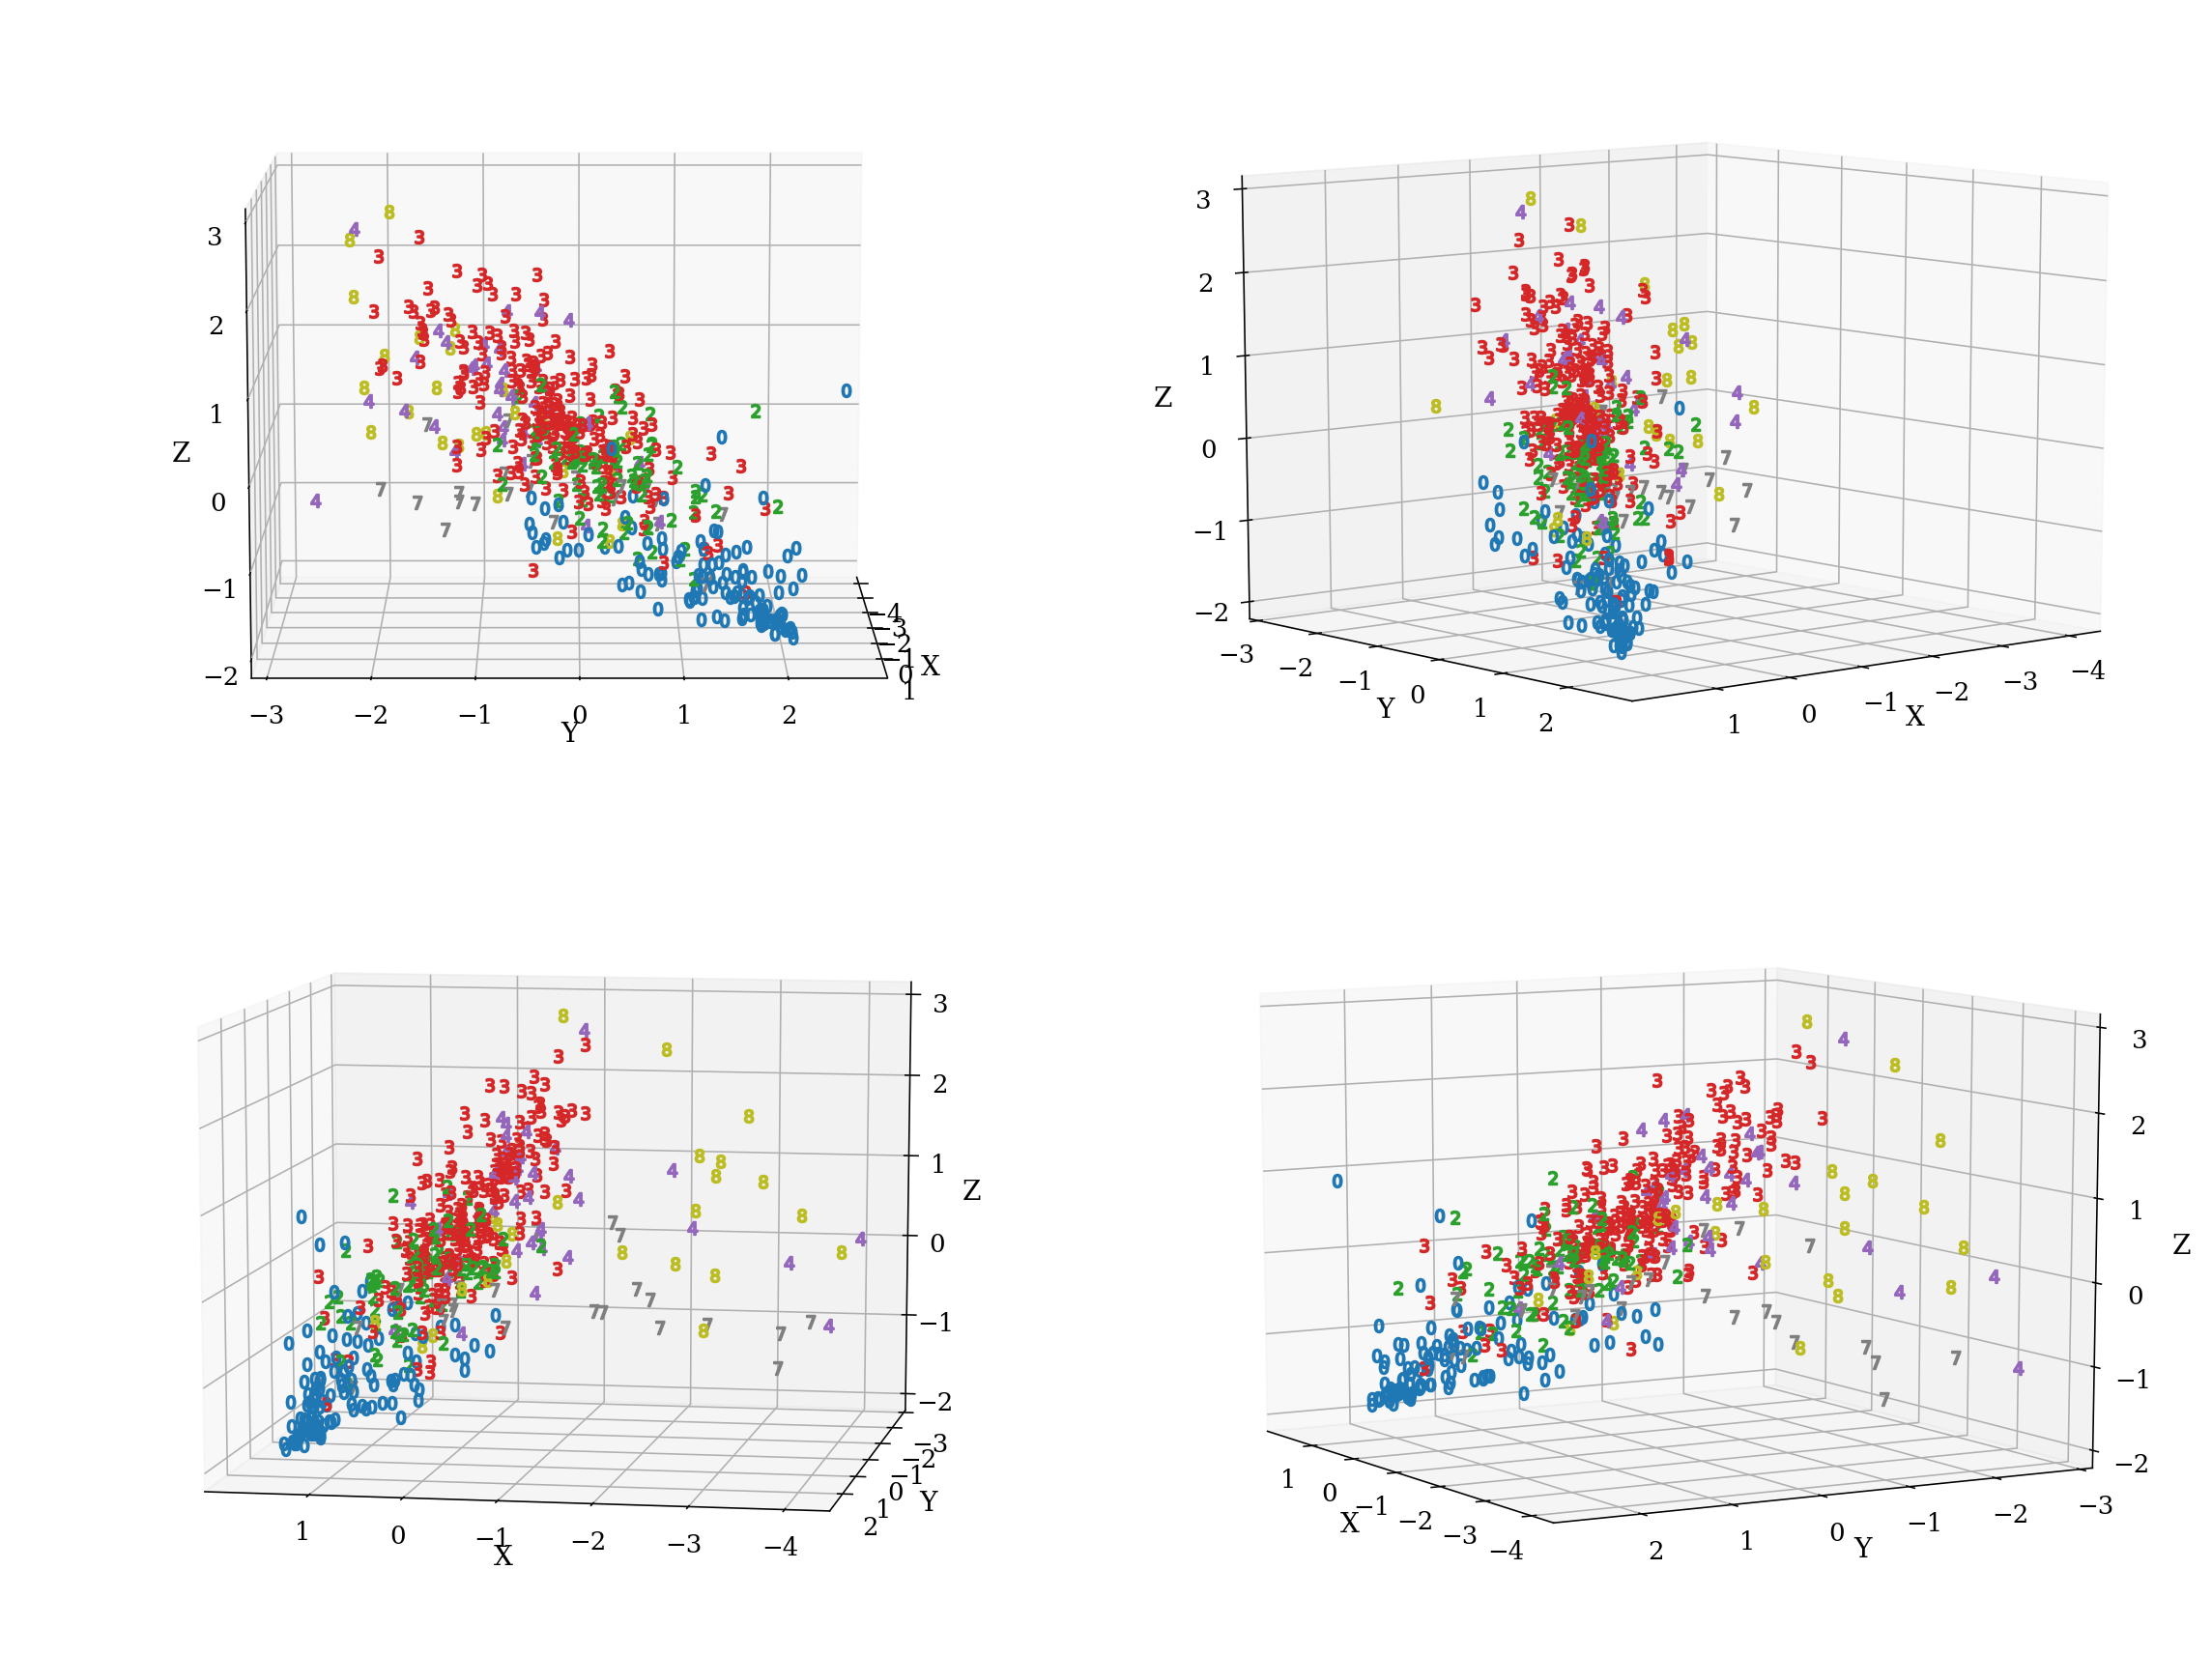

In [21]:
# Plot 3D latent space
if plot3DSample:
    %matplotlib inline

    latentVAll, labelVAll, _, _, _ = read_results(archHere,exHere)
    latentV, labelV = subsample(latentVAll, labelVAll)
    
    fig = plt.figure(figsize=(16, 12))

    for itr in range(4):
        ax = fig.add_subplot(2, 2, itr+1, projection='3d')

        count=0
        for row in latentV:
            lHere = labelV[count]
            ax.scatter(row[0], row[1], row[2],
                       marker='${}$'.format(lHere), 
                       s=45, c=[COLORS[lHere]])
            count += 1
                
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=10., azim=itr*50)

    if save3DSample:
        fileName = figPrefix + archHere + '_' + exHere + '_3DSample.png'
        plt.savefig(fileName,bbox_inches='tight')
    else:
        plt.tight_layout()
        plt.show()


### Interactive 3D Plot

In [22]:
plot3DI = False

In [23]:
# Create 3D Interactive Plot
if plot3DI:
    %matplotlib notebook
    
    latentVAll, labelVAll, _, _, _ = read_results(archHere,exHere)
    latentV, labelV = subsample(latentVAll, labelVAll)
        
    #plt.clf()
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    count=0
    for row in latentV:
        lHere = labelV[count]
        ax.scatter(row[0], row[1], row[2],
                   marker='${}$'.format(lHere), s=45, c=[COLORS[lHere]])
        count += 1
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    plt.show()

### Latent Vector PCA-Reduced Clustering

In [24]:
plotPCA = False
savePCA = True
nClustersPCA = 2

In [25]:
# Plot PCA Clustering
if plotPCA:
 
    n_clusters=2
    latentV, labelV, _, _, _ = read_results(archHere,exHere)

    reduced_data = PCA(n_components=2).fit_transform(latentV)
    kmeans = KMeans(init='k-means++', n_clusters=nClustersPCA, n_init=10)
    kmeans.fit(reduced_data)
    
    # step size of the mesh, decrease to increase quality
    h = 0.02
    
    # plot decision boundary, assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # obtain labels for each point in the mesh
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    
    # plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[1:, 0], centroids[1:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
    myTitle = archHere + ' ' + exHere.upper()
    plt.title(myTitle)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    if savePCA:
        fileName = figPrefix + archHere + '_' + exHere + '_' + str(nClustersPCA) + 'kmeansPCA.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)
    else:
        plt.show()


# 3 Latent Vector k-Means

### Perform k-Means

In [26]:
calcKMeans = False
saveKMeans = True
saveKFile = savePrefix + '_kClusters.pkl'

n_init = 10
miniK = False

In [27]:
# Perform k-Means
if calcKMeans:

    latentV, labelV, _, _, _ = read_results(archi, dataSet)
    
    # To subsample for testing, uncomment below:
    #latentV, labelV = subsample(latentV, labelV, nSamples=50)
    
    labelP = {}
    modelP = {}
    for n_clusters in range_n_clusters:
        
        print('Processing {} Clusters'.format(n_clusters))
        
        if miniK:
            # MiniBatch KMeans
            model = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++',
                                    n_init=n_init)
        else:
            model = KMeans(n_clusters=n_clusters, init='k-means++',
                           n_init=n_init)
            
        cluster_labels = model.fit_predict(latentV)
        labelP[n_clusters] = cluster_labels
        modelP[n_clusters] = model

        # To see the centers:
        #model.cluster_centers_
 
    print('Finished Processing')

    if saveKMeans:
        with open(saveKFile, 'wb') as handle:
          pickle.dump({'labelP':labelP,'latentV':latentV,'labelV':labelV,
                       'modelP':modelP}, 
                      handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved File: ', saveKFile)

### Calculate Silhouette Score

In [28]:
calcAveSS = False
saveAveSS = True
saveAveSSFile = savePrefix + '_avgSS.pkl'

calcSampleSS = False
saveSampleSS = True
saveSampleSSFile = savePrefix + '_sampleSS.pkl'

In [29]:
# Calculate the average silhouette score
if calcAveSS:
    
    if not exists('labelP'):
        print("Please perform k-Means analysis first!")
    else:
    
        silhScore = {}
        for n_clusters in range_n_clusters:
            cluster_labels = labelP[n_clusters]
        
            silhouette_avg = silhouette_score(latentV, cluster_labels)
            silhScore[n_clusters] = silhouette_avg
            print('Clusters: {}, Ave Silhouette: {:.3f}'.format(
                n_clusters, silhouette_avg))
        
        if saveAveSS:
            with open(saveAveSSFile, 'wb') as handle:
                pickle.dump(silhScore, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print('Saved File: ', saveAveSSFile)

In [30]:
# Calculate sample silhouette stats and scores
if calcSampleSS and not calcKMeans:
    print("Please perform k-Means analysis first!")

elif calcSampleSS:
    
    if not exists('silhScore'):
        inFile = saveSSFPrefix + '_avgSS.pkl'
        with open(inFile, 'rb') as handle:
            silhScore = pickle.load(handle)
    
    silhSamples = {}
    for n_clusters in range_n_clusters:
        cluster_labels = labelP[n_clusters]
        silhouette_avg = silhScore[n_clusters]
        
        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(latentV, cluster_labels)
        silhSamples[n_clusters] = sample_silhouette_values
        
        #Create a subplot with 1 row and 2 columns
        fig = plt.figure(figsize=(13,5))
        ax1 = fig.add_subplot(1, 2, 1)
        
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-.1,1])
        
        # The (n_clusters+1)*10 is for inserting blank space between 
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(latentV) + (n_clusters + 1)*10])
        
        y_lower=10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to 
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                             0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
            
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10
            
        ax1.set_title("Silhouette Plot for {} Clusters".format(n_clusters))
        ax1.set_xlabel("Silhouette Coefficient")
        ax1.set_ylabel("Cluster")
        
        # The vertical line for average silhouette score of all values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.2, 0.2, 0.6, 1])

        # Write out average silhouette score
        sString = 'Score = {:.2f}'.format(silhouette_avg)
        ax1.text(silhouette_avg+0.05, 11, sString)
        
        # 2nd Plot showing actual clusters formed
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(latentV[:,0], latentV[:,1], latentV[:,2],
                    marker='.', alpha=0.7, c=colors, edgecolor=colors)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('')
        ax2.set_title("Visualization of {} Clusters".format(n_clusters), loc='left')
        #ax2.view_init(elev=10., azim=20)
        
        if saveSS:
            fileName = figPrefix + '_' + str(n_clusters) + 'kSS.png'
            plt.savefig(fileName,bbox_inches='tight')
            print('Saved Figure: ',fileName)
            
        else:
            plt.show()
    
    if saveSampleSS:
        with open(saveSampleSSFile, 'wb') as handle:
          pickle.dump(silhSamples, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('Saved File: ', saveSampleSSFile)

### Plot Silhouette Samples

In [31]:
plotSampleSS = True
plotSaveSampleSS = False
nClusterSample = 3

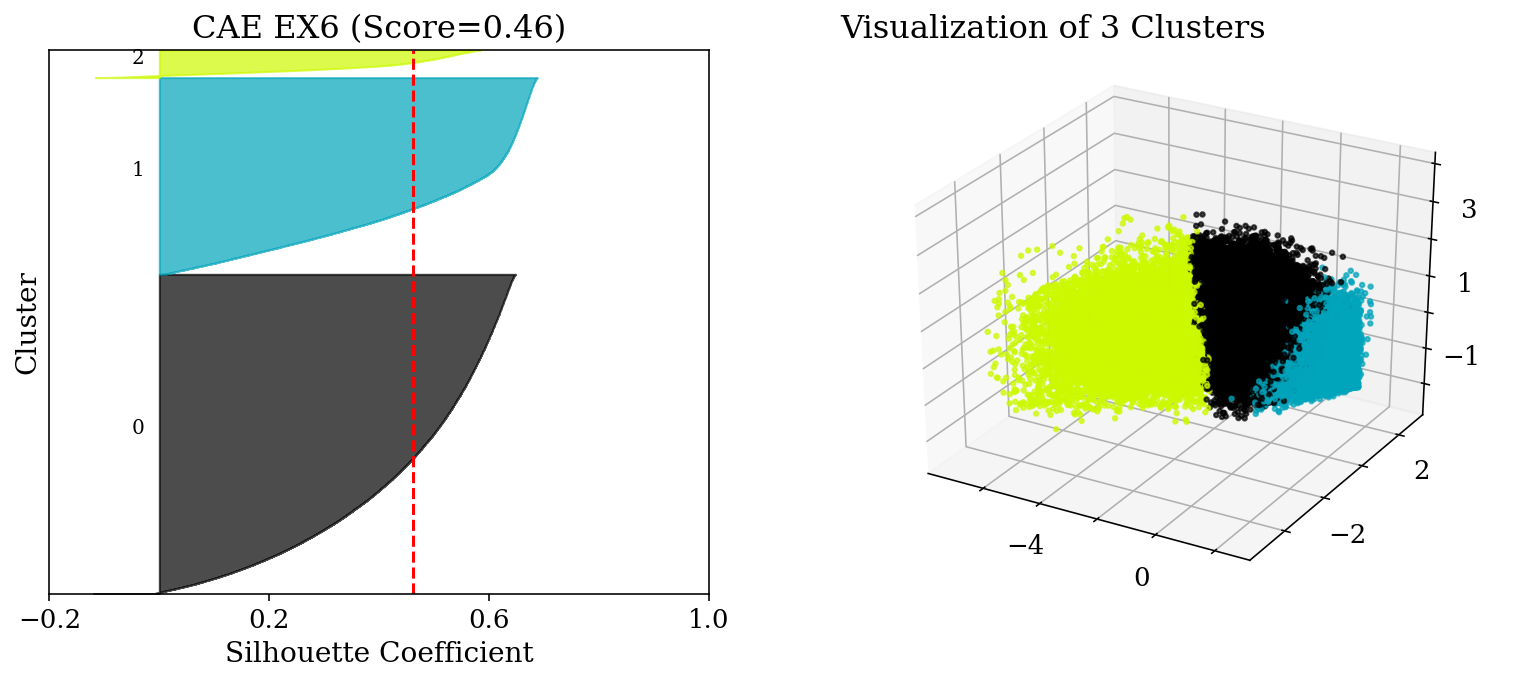

In [32]:
# Plot sample silhouette stats and scores
if plotSampleSS:
    
    # Load the samples
    with open(saveSampleSSFile, 'rb') as handle:
        silhSamples = pickle.load(handle)
    samplesHere = silhSamples[nClusterSample]
    
    # Load the clusters
    kDict = load_kMeans()
    labelP = kDict[archHere][exHere]['labelP'][nClusterSample]
    latentV = kDict[archHere][exHere]['latentV']

    # Load the average score
    with open(saveAveSSFile, 'rb') as handle:
        silhAveScoreAll = pickle.load(handle)
    silhAveScore = silhAveScoreAll[nClusterSample]
    
    # Plot
    plotTitle = archHere + ' ' + exHere.upper() + ' (Score={:.2f})'.format(silhAveScore)
    if plotSaveSampleSS:
        mySaveFile = figPrefix + archHere + '_' + exHere + str(nClusterSample) + 'kSS.png'
    else:
        mySaveFile = ''
    plotSilhSamples(nClusterSample, silhAveScore, samplesHere, labelP, latentV,
                    myTitle=plotTitle, mySave=plotSaveSampleSS, mySaveFile=mySaveFile)
                              

# 4 k-Means Score Results

### Adjusted Mutual Info Score

In [15]:
calcAMIS = True
saveAMIS = False
plotLegend = True

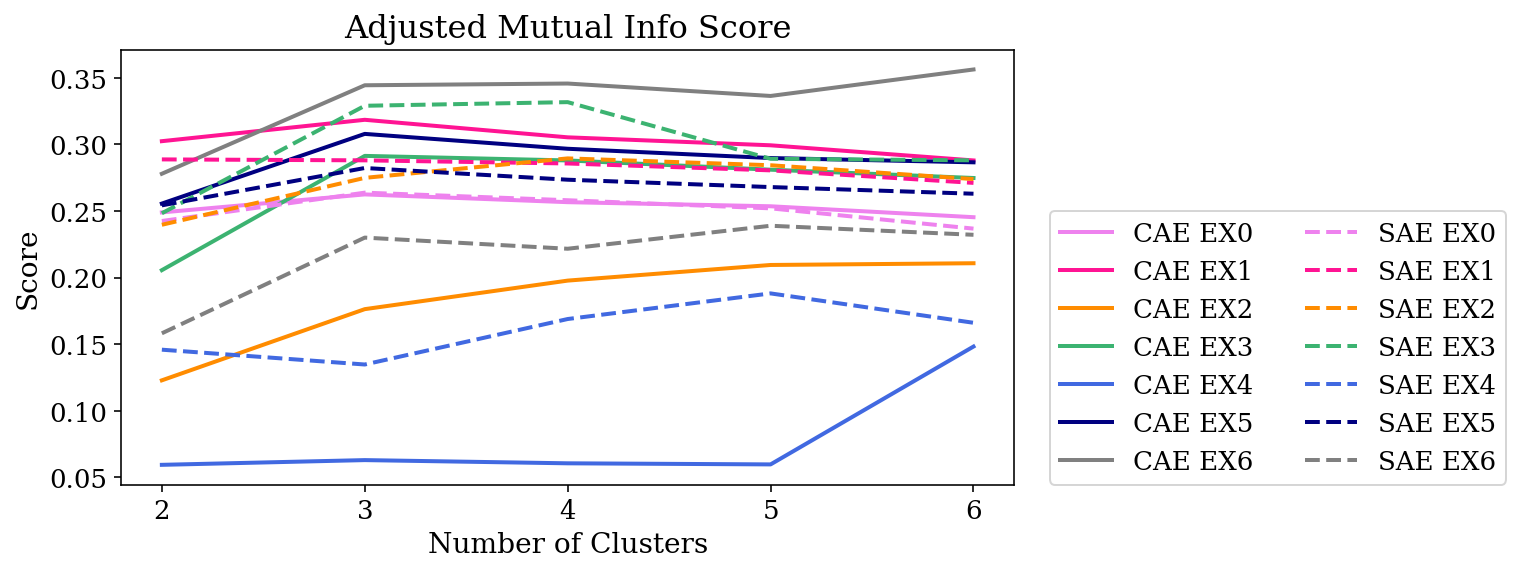

In [16]:
# Calculate and Plot Adjusted Mutual Info Score
if calcAMIS:
    
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            amisScore = []
            for n_clusters in range_n_clusters:
                predict = labelP[n_clusters]
                amisScore.append(adjusted_mutual_info_score(labelV,predict))

            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, amisScore,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
    
    ax.set_title("Adjusted Mutual Info Score")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0),ncol=2)
    
    if saveAMIS:
        fileName = figPrefix + 'score_adjMutualInfo.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### Adjusted Rand Index

In [35]:
calcARI = True
saveARI = False
plotLegend = False

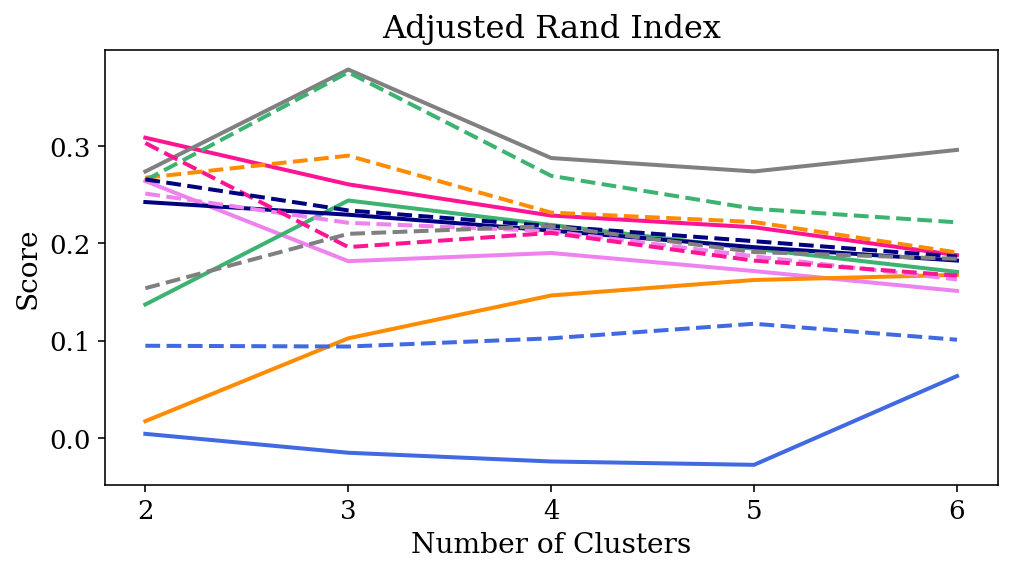

In [36]:
# Calculate and Plot Adjusted Rand Index
if calcARI:
        
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            ariScore = []
            for n_clusters in range_n_clusters:
                predict = labelP[n_clusters]
                ariScore.append(adjusted_rand_score(labelV,predict))

            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, ariScore,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
        
    ax.set_title("Adjusted Rand Index")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0))
    
    if saveARI:
        fileName = figPrefix + 'score_adjRandIndex.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### Average Silhouette Score

In [37]:
plotAveSilh = True
saveAveSilh = False
plotLegend = False

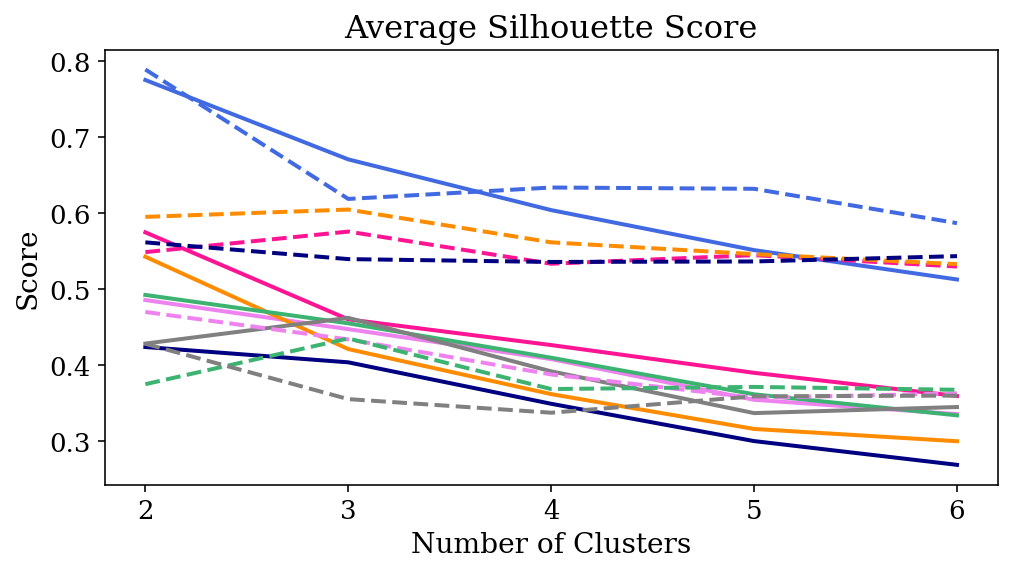

In [38]:
# Plot the average silhouette score
if plotAveSilh:

    aveSDict = load_aveSScore()
    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()

    countL=0
    for aa in archList:
        exDict = aveSDict[aa]
        
        countE=0
        for ee in exList:
            aveDict = exDict[ee]
            
            silhList = []
            for cl in range_n_clusters:
                silhList.append(aveDict[cl])
            
            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, silhList, 
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH,
                    label=myLabel)
            countE += 1
        countL += 1
        
    ax.set_title("Average Silhouette Score")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04,0))
    
    if saveAveSilh:
        fileName = figPrefix + 'score_avgSilh.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### Completeness Score

In [41]:
calcCS = True
saveCS = False
plotLegend = False

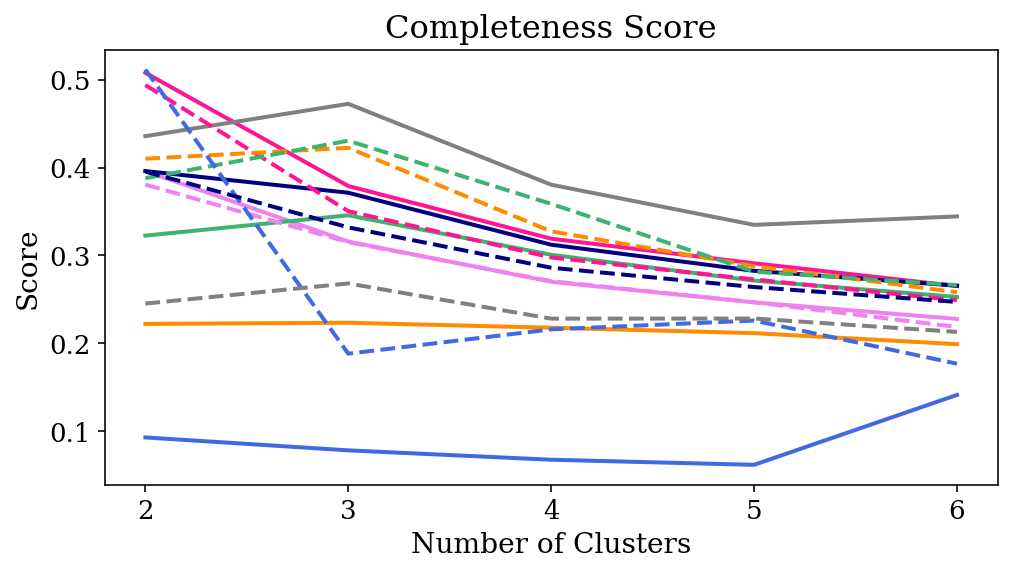

In [42]:
if calcCS:
       
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            cScore = []
            for n_clusters in range_n_clusters:
                predict = labelP[n_clusters]
                cScore.append(completeness_score(labelV,predict))

            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, cScore,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
       
    ax.set_title("Completeness Score")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0))
    
    if saveCS:
        fileName = figPrefix + 'score_completeness.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### Fowlkes-Mallows Index

In [43]:
calcFMI = True
saveFMI = False
plotLegend = False

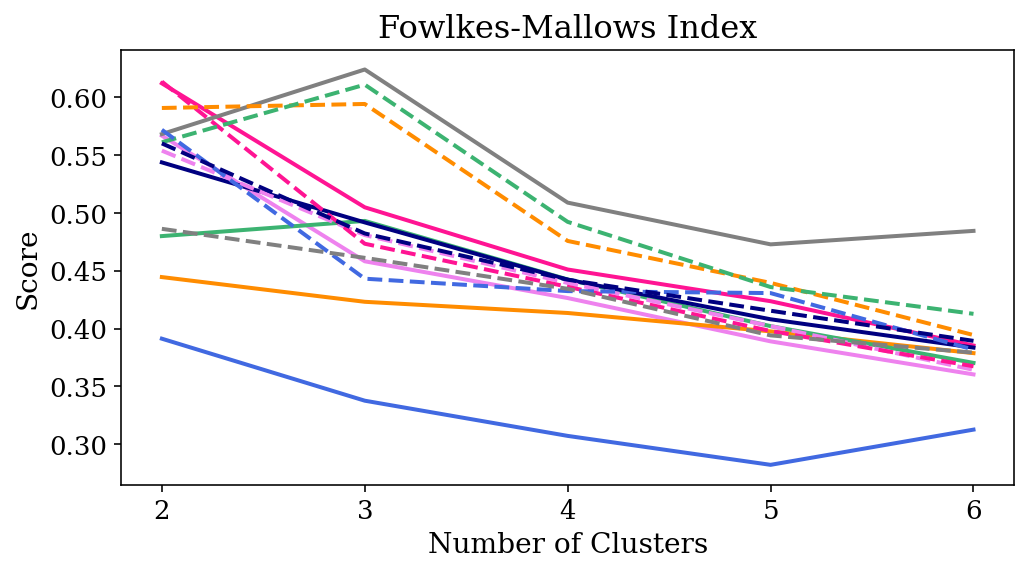

In [44]:
if calcFMI:
    
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            fmScore = []
            for n_clusters in range_n_clusters:
                predict = labelP[n_clusters]
                fmScore.append(fowlkes_mallows_score(labelV,predict))

            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, fmScore,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
        
    ax.set_title("Fowlkes-Mallows Index")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0))
    
    if saveFMI:
        fileName = figPrefix + 'score_FMI.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### Homogeneity Score

In [310]:
calcHS = True
saveHS = True
plotLegend = False

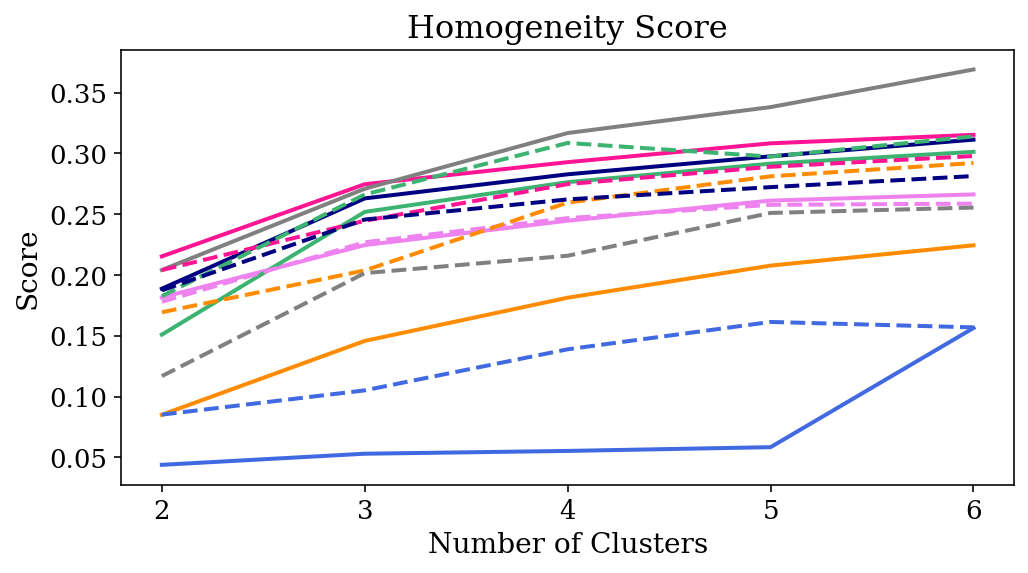

In [311]:
if calcHS:
    
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            hScore = []
            for n_clusters in range_n_clusters:
                predict = labelP[n_clusters]
                hScore.append(homogeneity_score(labelV,predict))

            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, hScore,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
        
    ax.set_title("Homogeneity Score")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0))
    
    if saveHS:
        fileName = figPrefix + 'score_homogeneity.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### Inertia (Sum-of-Square Distances)

In [45]:
plotInertia = True
saveInertia = False
plotLegend = False

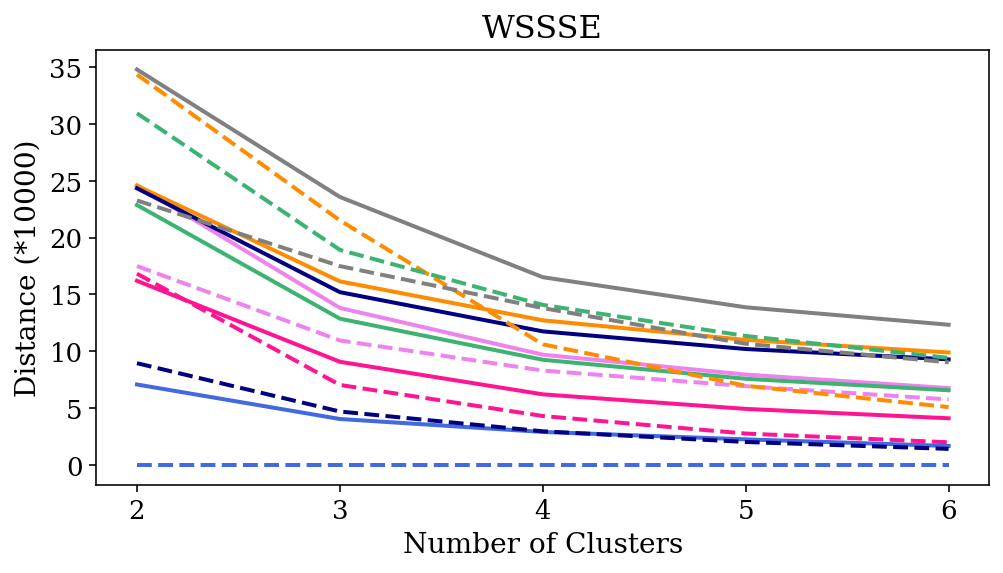

In [46]:
if plotInertia:
    
    divide_factor=[10000.,1000.]
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            modelP = varDict['modelP']
            inertia = []
            for cl in range_n_clusters:
                inertia.append(modelP[cl].inertia_)
            
            inertia = np.array(inertia)/divide_factor[countL]
            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, inertia,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
            
    myYLabel = "Distance (*" + str(int(divide_factor[0])) + ")"
    ax.set_title("WSSSE")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel(myYLabel)
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0))
    
    if saveInertia:
        fileName = figPrefix + 'score_wssse.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

### V-Measure Score

In [47]:
calcVMS = True
saveVMS = False
plotLegend = False

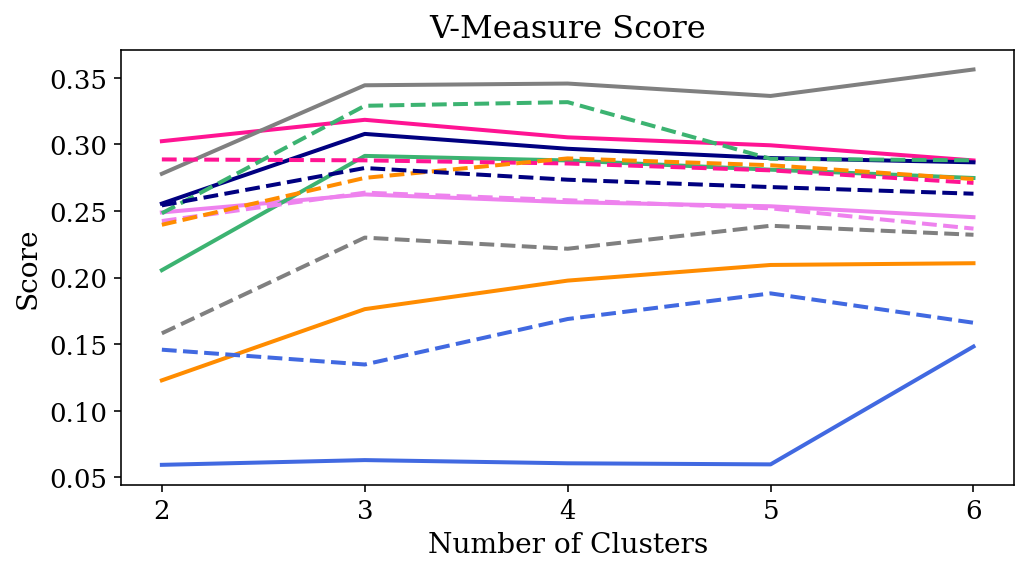

In [48]:
# Calculate and Plot V-Measure Score
if calcVMS:
    
    kDict = load_kMeans()

    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    
    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            vmScore = []
            for n_clusters in range_n_clusters:
                predict = labelP[n_clusters]
                vmScore.append(v_measure_score(labelV,predict))

            myLabel = aa + ' ' + ee.upper()
            ax.plot(range_n_clusters, vmScore,
                    color=EXCOLOR[countE],
                    linestyle=LSTYLE[countL], linewidth=EXLWIDTH, 
                    label=myLabel)
            countE += 1
        countL += 1
        
    ax.set_title("V-Measure Score")
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score")
    ax.set_xticks(range_n_clusters)
    if plotLegend:
        ax.legend(loc=(1.04, 0))
    
    if saveVMS:
        fileName = figPrefix + 'score_vmeasure.png'
        plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)

# 5 Prediction Results

### Prediction Counts

In [49]:
plotNPred = True
saveNPred = False
archList=['CAE']
exList=['ex6']

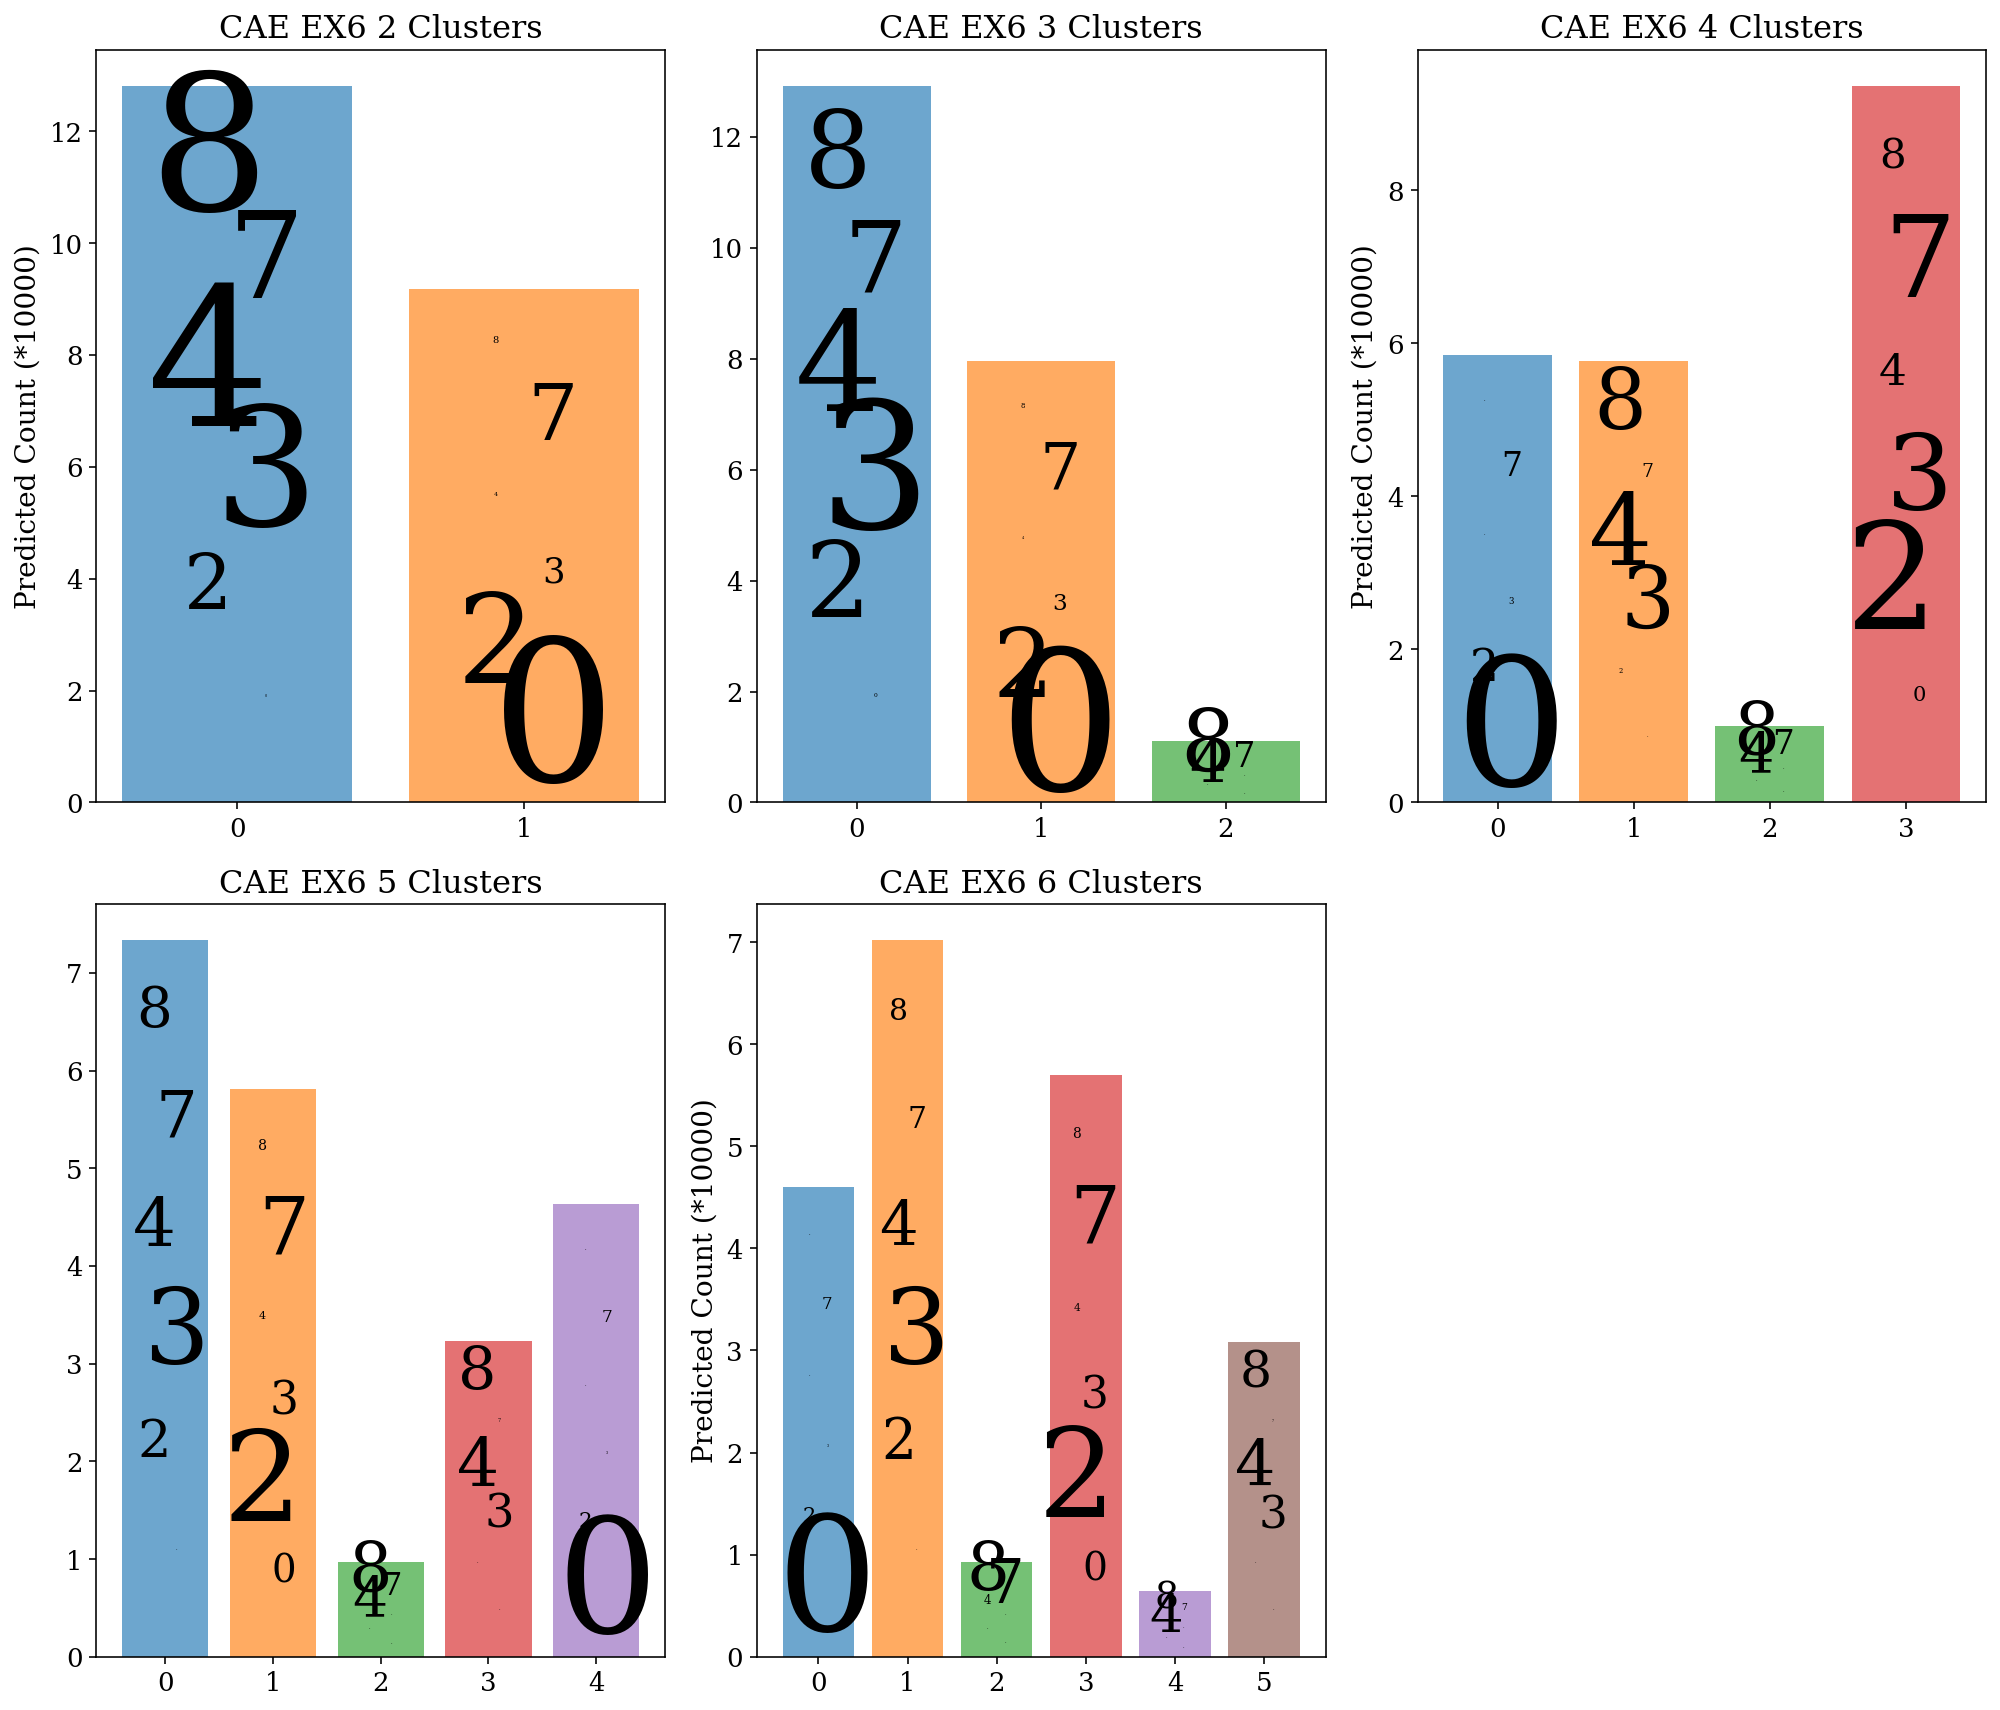

In [50]:
# Plot count of predictions
figXSize=14
figYSize=12
if plotNPred:

    valDivide=10000.
    kDict = load_kMeans()

    countL=0
    for aa in archList:
        exDict = kDict[aa]
        
        countE=0
        for ee in exList:
            varDict = exDict[ee]
            labelP = varDict['labelP']
            labelV = varDict['labelV']
            ctypes, ccounts = np.unique(labelV, return_counts=True)
            clabels = [str(i) for i in ctypes]
            nSamples = labelV.shape[0]
            nTypes = len(ctypes)
            #print('Data Samples: {} and Cloud Types: {}'.format(nSamples,nTypes))
    
            fig = plt.figure(figsize=(figXSize,figYSize))
            countP=1
            for n_clusters in range_n_clusters:
                # find number of matches
                pHere = labelP[n_clusters]
                ptypes, pcounts = np.unique(pHere, return_counts=True)

                tpLabels = np.empty([nSamples,2])
                tpLabels[:,0] = labelV
                tpLabels[:,1] = pHere
        
                result = np.empty([n_clusters,nTypes])
                for i in range(n_clusters):
                    for j in range(nTypes):
                        result[i,j] = np.count_nonzero(np.logical_and(
                            tpLabels[:,0] == ctypes[j],tpLabels[:,1]==i))
          
                # create plot
                pcounts = np.array(pcounts)/valDivide
                ax = fig.add_subplot(2,3,countP)
                ax.bar(ptypes, pcounts, alpha=0.65, color=COLORS[ptypes])
                ax.set_xticks(ptypes)
                #ax.set_xlabel('Cluster')
                if (countP % 2) == 1:
                    myYLabel = 'Predicted Count (*' + str(int(valDivide)) + ')'
                    ax.set_ylabel(myYLabel)
                myTitle = aa+' '+ee.upper()+' '+str(n_clusters)+' Clusters'
                ax.set_title(myTitle)
        
                mymax = np.max(pcounts)
                for i in range(n_clusters):
                    offset=0.1
                    for j in range(nTypes):
                        ax.text(ptypes[i]+offset,pcounts[i]*0.15*(j+1),ctypes[j],
                               fontsize=(100.*result[i,j]/ccounts[j]),
                               horizontalalignment='center',
                               verticalalignment='center')
                        offset*=-1.
                countP+=1
            
            if saveNPred:
                fileName = figPrefix + aa + '_' + ee + '_nPred.png'
                plt.savefig(fileName,bbox_inches='tight',dpi=FIGDPI)
                print("Saved Figure: ",fileName)
            else:
                plt.tight_layout()
                plt.show()